# Define imports

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pickle
try:
    import torch
    from torchvision.utils import make_grid
except ImportError:
    pass

import matplotlib
font = {'family' : "serif",
        'weight' : 'normal',
        'size'   : 9}
TITLE_FONTSIZE = 9
TICK_FONTSIZE = 8
matplotlib.rc('font', **font)
sns.set_palette('colorblind')

# Plots from Weighted Retraining Parameter Study

In [2]:
# Specify result and figure directories
result_root = Path("../../assets/official_results")
assert result_root.exists()
fig_root = Path("../../assets/official_figures")
fig_root.mkdir(exist_ok=True)

 

# Specify benchmarks and weight types
benchmarks = ["shapes", "expr", "chem"]
weight_types = ["rank", "cem-pi", "dbas", "fb", "rwr"]
titles = {
    "shapes": "2D Shape Area",
    "expr": "Arithmetic Expr.",
    "chem": "Chemical Design"
}
LINESTYLES = ['-', '--', '-.', ':'] * 2

 

# Specify k and r values for rank weighting
k_rank = ["1e-3", "inf", "1e-3", "inf", "1e-3", "1e-1"]
r_rank = [50, 50, 1000000, 1000000, 100, 50]
k_rank_shapes = k_rank  # ["inf", "1e-2", "inf", "1e-2", "1e-2", "1e1"]
r_rank_shapes = [5, 5, 1000000, 1000000, 50, 5]
k_dict = dict(shapes=k_rank_shapes, expr=k_rank, chem=k_rank)
r_dict = dict(shapes=r_rank_shapes, expr=r_rank, chem=r_rank)

 

# Specify q, r, alpha and n values for the baselines 
q_base_dict = dict(shapes=[0.8, 0.95], expr=[0.8, 0.95], chem=[0.8, 0.95])
r_base_dict = dict(shapes=[200, 500], expr=[200, 500], chem=[200, 500])
alpha_base_dict = dict(shapes=["1e-2", "1e-3"], expr=["1.0", "1e-1"], chem=["1.0", "1e-1"])
n_base_dict = dict(shapes=10, expr=0.1, chem=0.1)

 

results = {}
for benchmark in benchmarks:
    results[benchmark] = {}
    for weight_type in weight_types:
        results[benchmark][weight_type] = {}
            
        # Specify random seeds
        seeds = [1, 2, 3, 4, 5] if weight_type == "rank" else [1, 2, 3]
        
        # Load rank weighting results
        if weight_type == "rank":
            for k, r in zip(k_dict[benchmark], r_dict[benchmark]):
                results[benchmark][weight_type][f"k_{k}-r_{r}"] = {}
                for seed in seeds:
                    res_file = result_root / benchmark / weight_type / f"k_{k}" / f"r_{r}" / f"seed{seed}" / "results.npz"
                    if res_file.is_file():
                        results[benchmark][weight_type][f"k_{k}-r_{r}"][str(seed)] = np.load(res_file, allow_pickle=True)
                    
        # Load results for cem-pi, dbas and fb
        elif weight_type in ["cem-pi", "dbas", "fb"]:
            for q, r in itertools.product(q_base_dict[benchmark], r_base_dict[benchmark]):
                results[benchmark][weight_type][f"q_{q}-r_{r}"] = {}
                for seed in seeds:
                    if weight_type == "dbas":
                        res_file = result_root / benchmark / weight_type / f"q_{q}" / f"r_{r}" / f"n_{n_base_dict[benchmark]}" / f"seed{seed}" / "results.npz"
                    else:
                        res_file = result_root / benchmark / weight_type / f"q_{q}" / f"r_{r}" / f"seed{seed}" / "results.npz"
                    results[benchmark][weight_type][f"q_{q}-r_{r}"][str(seed)] = np.load(res_file)
        
        # Load results for rwr
        elif weight_type == "rwr":
            for r, alpha in itertools.product(r_base_dict[benchmark], alpha_base_dict[benchmark], ):
                results[benchmark][weight_type][f"r_{r}-alpha_{alpha}"] = {}
                for seed in seeds:
                    res_file = result_root / benchmark / weight_type / f"r_{r}" / f"alpha_{alpha}" / f"seed{seed}" / "results.npz"
                    results[benchmark][weight_type][f"r_{r}-alpha_{alpha}"][str(seed)] = np.load(res_file)

In [3]:
# Also load train data
train_data = dict()

# Shapes
with np.load("../../data/shapes/squares_G64_S1-20_seed0_R10_mnc32_mxc33.npz") as npz:
    train_data["shapes"] = npz["areas"]
    
# Expr
with np.load("../../assets/data/expr/scores_all.npz") as npz:
    expr_data = npz['arr_0']
perc_idx = expr_data >= np.percentile(expr_data, 50)
train_data["expr"] = -expr_data[perc_idx]

with open("../../assets/data/expr/equation2_15_dataset.txt") as f:
    eqs = f.readlines()
for i in range(len(eqs)):
    eqs[i] = eqs[i].strip().replace(' ', '')
inputs = list(np.array(eqs)[perc_idx])

# Chem
with open("../../data/chem/zinc/orig_model/pen_logP_all.pkl", "rb") as f:
    chem_props = pickle.load(f)
with open("../../data/chem/zinc/orig_model/train.txt") as f:
    smiles_list = [s.strip() for s in f.readlines()]
train_data["chem"] = np.array([chem_props[s] for s in smiles_list])
del smiles_list, chem_props

# Train data histograms

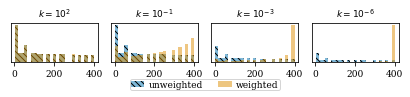

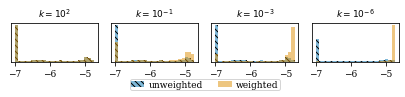

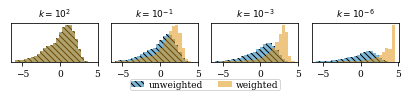

In [4]:
# Don't make it necessarily depend on 
try:
    from weighted_retraining import utils
    
    k_list = [1e2, 1e-1, 1e-3, 1e-6]
    hist_kwargs = dict(density=True, alpha=0.5, bins=25)
    for benchmark, dat in train_data.items():
        fig, axes = plt.subplots(1, len(k_list), figsize=(5.5,1.2))
        
        # Modify data if for chem
        if benchmark == "chem":
            dat = dat[dat > -6]
        
        for i, (k, ax) in enumerate(zip(k_list, axes)):
            plt.sca(ax)
            ax.axes.yaxis.set_visible(False)
            # Unweighted
            h = plt.hist(dat, **hist_kwargs, label="unweighted", hatch=r"\\\\", linewidth=0.5)
            
            # Weighted
            plt.hist(dat, **hist_kwargs, weights=utils.DataWeighter.rank_weights(dat, k),
                    label="weighted")#, hatch=r"////", linewidth=0.5)
            plt.title(f"$k=10^{{{np.log10(k):.0f}}}$", fontsize=TITLE_FONTSIZE)


        # Joint legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ncol = len(by_label.keys())
        fig.legend(by_label.values(), by_label.keys(), ncol=ncol, loc="upper center", bbox_to_anchor=(0.5, 0.15), columnspacing=1.7, borderpad=0.1, 
                   labelspacing=0.05, borderaxespad=0.01, handletextpad=0.5, handlelength=1.5)
        plt.tight_layout()
        plt.subplots_adjust(left=0.01, right=0.99, top=0.8, bottom=0.35, wspace=0.15)
        plt.savefig(fig_root / f"train-data-hist-{benchmark}.pdf")
        plt.show()
        
        

except ImportError:
    print("Can't load weighted_retraining library")

## Make violin plots

In [5]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def make_violin_plot(ax, data, labels):
    colors = ["tab:pink"] + ["tab:gray", "tab:cyan"] * 3
    hatches = ["////"] + [r"\\\\", "---"] * 3
    data_all = [data[t] for t in data]
    inds = [1, 2.15, 2.85, 4.15, 4.85, 6.15, 6.85]
    vplot = ax.violinplot(data_all, showmeans=False, showmedians=False, showextrema=False, positions=inds, widths=0.6)

    for patch, color, hatch in zip(vplot['bodies'], colors, hatches): 
        patch.set_color(color)
        patch.set_hatch(hatch)
        patch.set_edgecolor('black')
        patch.set_alpha(1.0)
        patch.set_linewidth(0.5)
        patch.set_zorder(2)

    # Calculate quartiles for uneven array sizes
    calc_data_percentile = lambda p : np.array([np.percentile(d, p) for d in data_all] )
    
    quartile1, medians, quartile3 = calc_data_percentile(25), calc_data_percentile(50), calc_data_percentile(75)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data_all, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    ax.scatter(inds, medians, marker='o', color='white', s=0.5, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=1.5)
    ax.grid(axis='y', zorder=0.0)
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)

    plt.sca(ax)
    plt.xlabel(r"rank weight k")
    plt.xticks([1, 2.5, 4.5, 6.5], labels)

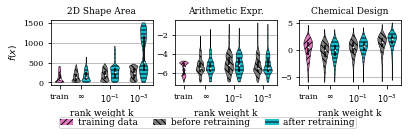

<Figure size 432x288 with 0 Axes>

In [6]:
labels = {k: ["train", r"$\infty$", r"$10^{-1}$", r"$10^{-3}$"] for k in "shapes expr chem".split()}
ks = {
    "shapes": ["inf", "1e-1", "1e-3"],
    "expr": ["inf", "1e-1", "1e-3"],
    "chem": ["inf", "1e-1", "1e-3"],
}
invalid_score = {
    "shapes": 0,
    "expr": -7,
    "chem": -6,
}

benchmarks_to_plot = ["shapes", "expr", "chem"]

violin_data = {}
for benchmark in benchmarks_to_plot:
    fac = -1 if benchmark == "expr" else 1
    violin_data[benchmark] = dict(train=train_data[benchmark])
    for k in ks[benchmark]:
        r = r_dict[benchmark][1]
        for mode, idx in zip(["pre", "post"], [0, -1]):
            violin_data[benchmark][f"k_{k}_{mode}"] = []
            for seed in results[benchmark]["rank"][f"k_{k}-r_{r}"]:
                violin_data[benchmark][f"k_{k}_{mode}"] += list(fac * results[benchmark]["rank"][f"k_{k}-r_{r}"][seed]["sample_properties"][idx])
            
# Filter out invalid scores
for benchmark in violin_data:
    for method in violin_data[benchmark]:
        violin_data[benchmark][method] = np.array([d for d in violin_data[benchmark][method] if d > invalid_score[benchmark]])
        
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5.5,1.75))
for ax, benchmark in zip([ax1, ax2, ax3], benchmarks_to_plot):
    make_violin_plot(ax, violin_data[benchmark], labels=labels[benchmark])
    plt.sca(ax)
    plt.title(titles[benchmark], fontsize=TITLE_FONTSIZE)
    if benchmark == "shapes":
        plt.ylabel(r"$f(x)$")

from matplotlib.patches import Patch
patches = [Patch(facecolor='tab:pink', hatch='////', alpha=1.0), Patch(facecolor='tab:gray', hatch=r'\\\\'), Patch(facecolor='tab:cyan', hatch='---')]
labels = ['training data', 'before retraining', 'after retraining']
plt.tight_layout()

fig.legend(patches, labels, ncol=len(labels), loc="upper center", bbox_to_anchor=(0.5, 0.11), columnspacing=1.7, borderpad=0.1, labelspacing=0.05, borderaxespad=0.01, handletextpad=0.5, handlelength=1.5)


plt.subplots_adjust(left=0.105, right=0.99, top=0.88, bottom=0.36, wspace=0.22)
plt.savefig(fig_root / "violin.pdf")
plt.show()
plt.clf()

# Make optimization plots

In [7]:
def make_optimization_plot(ax, data, n_queries, labels, benchmark, titles, to_plot, metric="top1"):
    query_idx = range(1, n_queries+1)
    idx = 0
    for method in data["rank"]:
        if method not in to_plot[benchmark]:
            continue
        scores = []
        for seed in data["rank"][method]:
            fac = -1 if benchmark == "expr" else 1
            all_scores = fac * np.array(data["rank"][method][seed]["opt_point_properties"])
                
            if metric == "top1":
                scores.append(np.array([np.max(all_scores[:q]) for q in query_idx]))
            else:
                
                # Gotta check uniqueness!!!
                K = int(metric.split('top')[1])
                all_points = np.array(data["rank"][method][seed]["opt_points"])
                
                # If shapes, convert to strings?
                if benchmark == "shapes":
                    all_points = np.array(["".join([str(int(i)) for i in a.flatten()]) for a in all_points])
                elif benchmark == "expr":
                    all_points = np.array([str(v) for v in all_points])
                elif benchmark == "chem":
                    all_points = np.array(["" if v is None else str(v) for v in all_points])
                
                topK_scores = []
                for q in query_idx:                   
                    uniq_idxs = np.unique(all_points[:q], axis=0, return_index=True)[1]
                    sorted_scores = sorted(all_scores[uniq_idxs], reverse=True)
                    
                    try:
                        s = sorted_scores[min(K-1, q-1)]
                    except IndexError:
                        s = sorted_scores[-1]
                    topK_scores.append(s)
                scores.append(np.array(topK_scores))
        scores_mean = np.nanmean(np.array(scores), axis=0)
        
        scores_std = np.nanstd(np.array(scores), axis=0)

 

        ax.plot(query_idx, scores_mean, label=labels[method], linewidth=1, linestyle=LINESTYLES[idx])
        ax.fill_between(query_idx, scores_mean-scores_std, scores_mean+scores_std, alpha=0.3)
        idx += 1
 
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)
    plt.sca(ax)
    plt.title(titles[benchmark], fontsize=TITLE_FONTSIZE)
    plt.xlabel(r"Num. eval. of $f$")
    plt.xlim([0, n_queries])
    if benchmark == "expr" and metric == "top1":
        plt.ylim([-3.5, -0.3]) 
    elif benchmark == "chem":
        plt.ylim([0, 26]) 
        
    if benchmark == "shapes":
        plt.ylabel(f"{metric.title()} score")

top1


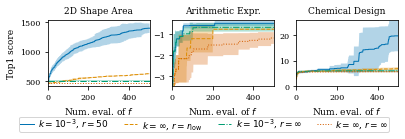

top10


<Figure size 432x288 with 0 Axes>

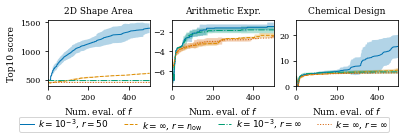

top50


<Figure size 432x288 with 0 Axes>

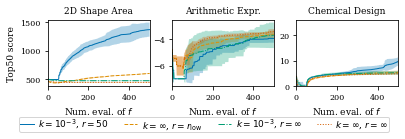

<Figure size 432x288 with 0 Axes>

In [8]:
labels = {
    "k_inf-r_1000000": r"$k=\infty$, $r=\infty$",
    "k_1e-3-r_50": r"$k=10^{-3}$, $r=r_{\mathrm{low}}$",
    "k_inf-r_50": r"$k=\infty$, $r=r_{\mathrm{low}}$",
    "k_1e-3-r_1000000": r"$k=10^{-3}$, $r=\infty$",
    "k_1e-3-r_100": r"$k=10^{-3}$, $r=100$",
    "k_1e-1-r_50": r"$k=10^{-1}$, $r=50$",
    "k_1e-3-r_5": r"$k=10^{-3}$, $r=5$",
    "k_inf-r_5": r"$k=\infty$, $r=5$",
    "k_1e-3-r_1000000": r"$k=10^{-3}$, $r=\infty$",
    "k_1e-3-r_50": r"$k=10^{-3}$, $r=50$",
    "k_1e-1-r_5": r"$k=10^{-1}$, $r=5$",
}

to_plot = {
    "shapes": ["k_1e-3-r_5", "k_1e-3-r_1000000", "k_inf-r_5", "k_inf-r_1000000"],
    "expr": ["k_1e-3-r_50", "k_1e-3-r_1000000", "k_inf-r_50", "k_inf-r_1000000"],
    "chem": ["k_1e-3-r_50", "k_1e-3-r_1000000", "k_inf-r_50", "k_inf-r_1000000"],
}


benchmarks_to_plot = ["shapes", "expr", "chem"]

for metric in "top1 top10 top50".split():
    print(metric)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5.5,1.75))
    for ax, benchmark in zip([ax1, ax2, ax3], benchmarks_to_plot):
        make_optimization_plot(ax, results[benchmark], n_queries=500, labels=labels, 
                               benchmark=benchmark, titles=titles, metric=metric, to_plot=to_plot)

    handles, legend_labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(legend_labels, handles))
    ncol = len(by_label.keys())

    fig.legend(list(by_label.values()), list(by_label.keys()), ncol=ncol, loc="upper center",
               bbox_to_anchor=(0.5, 0.11), columnspacing=1.7, borderpad=0.1, labelspacing=0.05, 
               borderaxespad=0.01, handletextpad=0.5, handlelength=1.5)
    plt.tight_layout()
    plt.subplots_adjust(left=0.105, right=0.99, top=0.88, bottom=0.35, wspace=0.22)
    plt.savefig(fig_root / f"optimization-{metric}.pdf")
    plt.show()
    plt.clf()

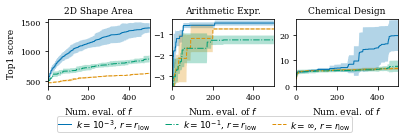

<Figure size 432x288 with 0 Axes>

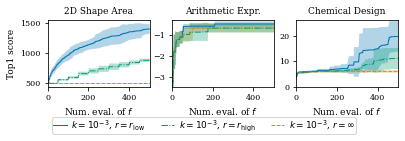

<Figure size 432x288 with 0 Axes>

In [9]:
labels = {
    "shapes": {
        "k_inf-r_1000000": r"$k=\infty$, $r=\infty$",
        "k_1e-3-r_50": r"$k=10^{-3}$, $r=r_{\mathrm{high}}$",
        "k_inf-r_50": r"$k=\infty$, $r=r_{\mathrm{high}}$",
        "k_1e-3-r_1000000": r"$k=10^{-3}$, $r=\infty$",
        "k_1e-3-r_100": r"$k=10^{-3}$, $r=100$",
        "k_1e-1-r_50": r"$k=10^{-1}$, $r=r_{\mathrm{high}}$",
        "k_1e-3-r_5": r"$k=10^{-3}$, $r=r_{\mathrm{low}}$",
        "k_inf-r_5": r"$k=\infty$, $r=r_{\mathrm{low}}$",
        "k_1e-3-r_1000000": r"$k=10^{-3}$, $r=\infty$",
        "k_1e-1-r_5": r"$k=10^{-1}$, $r=r_{\mathrm{low}}$",
    },
    "expr": {
        "k_inf-r_1000000": r"$k=\infty$, $r=\infty$",
        "k_1e-3-r_50": r"$k=10^{-3}$, $r=r_{\mathrm{low}}$",
        "k_inf-r_50": r"$k=\infty$, $r=r_{\mathrm{low}}$",
        "k_1e-3-r_1000000": r"$k=10^{-3}$, $r=\infty$",
        "k_1e-3-r_100": r"$k=10^{-3}$, $r=r_{\mathrm{high}}$",
        "k_1e-1-r_50": r"$k=10^{-1}$, $r=r_{\mathrm{low}}$",
        "k_1e-3-r_5": r"$k=10^{-3}$, $r=5$",
        "k_inf-r_5": r"$k=\infty$, $r=5$",
        "k_1e-3-r_1000000": r"$k=10^{-3}$, $r=\infty$",
        "k_1e-1-r_5": r"$k=10^{-1}$, $r=5$",
    },
    "chem": {
        "k_inf-r_1000000": r"$k=\infty$, $r=\infty$",
        "k_1e-3-r_50": r"$k=10^{-3}$, $r=r_{\mathrm{low}}$",
        "k_inf-r_50": r"$k=\infty$, $r=r_{\mathrm{low}}$",
        "k_1e-3-r_1000000": r"$k=10^{-3}$, $r=\infty$",
        "k_1e-3-r_100": r"$k=10^{-3}$, $r=r_{\mathrm{high}}$",
        "k_1e-1-r_50": r"$k=10^{-1}$, $r=r_{\mathrm{low}}$",
        "k_1e-3-r_5": r"$k=10^{-3}$, $r=5$",
        "k_inf-r_5": r"$k=\infty$, $r=5$",
        "k_1e-3-r_1000000": r"$k=10^{-3}$, $r=\infty$",
        "k_1e-1-r_5": r"$k=10^{-1}$, $r=5$",
    }
}

to_plot_r_fixed = {
    "shapes": ["k_1e-3-r_5", "k_1e-1-r_5", "k_inf-r_5"],
    "expr": ["k_1e-3-r_50", "k_1e-1-r_50", "k_inf-r_50"],
    "chem": ["k_1e-3-r_50", "k_1e-1-r_50", "k_inf-r_50"],
}

to_plot_k_fixed = {
    "shapes": ["k_1e-3-r_5", "k_1e-3-r_50", "k_1e-3-r_1000000"],
    "expr": ["k_1e-3-r_50", "k_1e-3-r_100", "k_1e-3-r_1000000"],
    "chem": ["k_1e-3-r_50", "k_1e-3-r_100", "k_1e-3-r_1000000"],
}


benchmarks_to_plot = ["shapes", "expr", "chem"]

for to_plot, name in zip([to_plot_r_fixed, to_plot_k_fixed], ["r_fixed", "k_fixed"]):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5.5,1.75))
    for ax, benchmark in zip([ax1, ax2, ax3], benchmarks_to_plot):
        make_optimization_plot(ax, results[benchmark], n_queries=500, labels=labels[benchmark], 
                               benchmark=benchmark, titles=titles, metric="top1", to_plot=to_plot)

 

    handles, legend_labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(legend_labels, handles))
    ncol = len(by_label.keys())
    
    values = list(by_label.values())
    keys = list(by_label.keys())
    values = [values[0], values[2], values[1]]
    keys = [keys[0], keys[2], keys[1]]
    fig.legend(values, keys, ncol=ncol, loc="upper center", bbox_to_anchor=(0.5, 0.11), columnspacing=1.7, borderpad=0.1, labelspacing=0.05, borderaxespad=0.01, handletextpad=0.5, handlelength=1.5)
    plt.tight_layout()
    plt.subplots_adjust(left=0.105, right=0.99, top=0.88, bottom=0.35, wspace=0.22)
    plt.savefig(fig_root / f"optimization-top1-{name}.pdf")
    plt.show()
    plt.clf()

# Make baseline plots

In [10]:
def make_baseline_plot(ax, data, n_queries_base, n_queries_ours, labels, benchmark, metric="top1"):
    idx = 0
    for baseline in data:
        for method in data[baseline]:
            if f"{baseline}-{method}" not in labels[benchmark]:
                continue
                                
            query_idx = range(1, n_queries_ours+1 if baseline == "rank" else n_queries_base+1)
            scores = []
            for seed in data[baseline][method]:
                fac = -1 if benchmark == "expr" else 1
                all_scores = fac * np.array(data[baseline][method][seed]["opt_point_properties"])
                
                if metric == "top1":
                    scores.append(np.array([np.max(all_scores[:q]) for q in query_idx]))
                else:
                    K = int(mode.split('top')[1])
                    scores.append(np.array([sorted(all_scores[:q])[::-1][min(K-1, q-1)] for q in query_idx]))

            scores_mean = np.nanmean(np.array(scores), axis=0)
            scores_std = np.nanstd(np.array(scores), axis=0) / np.sqrt(len(seeds))

            ax.semilogx(query_idx, scores_mean, label=labels[benchmark][f"{baseline}-{method}"], linestyle=LINESTYLES[idx])
            ax.fill_between(query_idx, scores_mean-scores_std, scores_mean+scores_std, alpha=0.3)
            idx += 1

    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9), numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.tick_params(labelsize=TICK_FONTSIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)
    ax.grid()
    
    plt.sca(ax)
    plt.title(titles[benchmark], fontsize=TITLE_FONTSIZE)
    plt.xlabel(r"Num. eval. of $f$ (log)")
    plt.xticks([1, 10, 100, 1000, 10000])
    plt.xlim([1, 10000])
    if benchmark == "expr":
        plt.ylim([-6, 0]) 
    elif benchmark == "chem":
        plt.ylim([0, 24]) 
    elif benchmark == "shapes":
        plt.ylim([0, 1600])
        plt.ylabel("Top1 score")

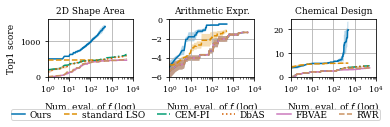

<Figure size 432x288 with 0 Axes>

In [11]:
labels = {
    "shapes": {
        "rank-k_1e-3-r_5": "Ours",
        "rank-k_inf-r_1000000": "standard LSO",
        "dbas-q_0.95-r_200": "DbAS",
        "cem-pi-q_0.95-r_200": "CEM-PI",
        "fb-q_0.95-r_200": "FBVAE",
        "rwr-r_200-alpha_1e-3": "RWR"
    },
    "expr": {
        "rank-k_1e-3-r_50": "Ours",
        "rank-k_inf-r_1000000": "standard LSO",
        "dbas-q_0.95-r_200": "DbAS",
        "cem-pi-q_0.95-r_200": "CEM-PI",
        "fb-q_0.95-r_200": "FBVAE",
        "rwr-r_200-alpha_1e-1": "RWR",
    },
    "chem": {
        "rank-k_1e-3-r_50": "Ours",
        "rank-k_inf-r_1000000": "standard LSO",
        "dbas-q_0.95-r_200": "DbAS",
        "cem-pi-q_0.95-r_200": "CEM-PI",
        "fb-q_0.95-r_200": "FBVAE",
        "rwr-r_200-alpha_1e-1": "RWR",
    }
}

benchmarks_to_plot = ["shapes", "expr", "chem"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5.5,1.75))
for ax, benchmark in zip([ax1, ax2, ax3], benchmarks_to_plot):
    make_baseline_plot(ax, results[benchmark], 5000, 500, labels, benchmark)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ncol = len(by_label.keys())

fig.legend(by_label.values(), by_label.keys(), ncol=ncol, loc="upper center", bbox_to_anchor=(0.5, 0.11), columnspacing=1.3, borderpad=0.1, labelspacing=0.05, borderaxespad=0.01, handletextpad=0.5, handlelength=1.5)
plt.subplots_adjust(left=0.105, right=0.99, top=0.88, bottom=0.35, wspace=0.22)

plt.tight_layout()
plt.savefig(fig_root / "baselines.pdf")
plt.show()
plt.clf()

# Chem Task Results/Table/Images

In [12]:
print("Baseline")
res_list = []
for seed, npz in results["chem"]["rank"][f"k_inf-r_1000000"].items():
    res = npz["opt_point_properties"]
    
    res_list.append(np.sort(res)[::-1][:5])
top_vals = [r[0] for r in res_list]
top_val_argsort = np.argsort(top_vals)
for i in top_val_argsort:
    print(res_list[i])
    
    
print("No retraining")
res_list = []
for seed, npz in results["chem"]["rank"][f"k_1e-3-r_1000000"].items():
    res = npz["opt_point_properties"]
    
    res_list.append(np.sort(res)[::-1][:5])
top_vals = [r[0] for r in res_list]
top_val_argsort = np.argsort(top_vals)
for i in top_val_argsort:
    print(res_list[i])
    
    
print("WR")
res_list = []
for seed, npz in results["chem"]["rank"][f"k_1e-3-r_50"].items():
    res = npz["opt_point_properties"]
    
    res_list.append(np.sort(res)[::-1][:5])
top_vals = [r[0] for r in res_list]
top_val_argsort = np.argsort(top_vals)
for i in top_val_argsort:
    print(res_list[i])

Baseline
[5.28263178 5.23901391 5.17904979 5.09219483 5.07461078]
[5.6431327  5.54987725 5.41086736 5.33244582 5.32557972]
[5.64640958 5.62957186 5.43312145 5.24264289 5.23906761]
[5.83120297 5.67180344 5.66873154 5.61500983 5.60812384]
[6.16151685 5.91268463 5.75566801 5.75557867 5.73197376]
No retraining
[5.55121667 5.27811186 5.27182609 5.09573675 5.04682025]
[5.72399255 5.65382378 5.61615992 5.58237706 5.55759892]
[5.95634574 5.74574712 5.71549508 5.68752641 5.67995485]
[5.96236332 5.70105153 5.61832049 5.61230384 5.59411143]
[6.97278738 6.97278738 6.97278738 6.97278738 6.97278738]
WR
[10.52086834 10.52086834 10.38390144 10.1583184  10.1583184 ]
[15.68625701 15.28485801 15.28008791 15.27194071 15.26334121]
[21.19875509 15.34469472 15.33621314 15.32627641 15.29405975]
[23.03701756 18.10347184 18.1004714  15.30862769 14.99797643]
[27.83843444 27.59103098 27.20549996 25.89861124 25.36749935]


In [13]:
try:
    from rdkit import Chem
    from rdkit.Chem import Draw
    
    props = results["chem"]["rank"][f"k_1e-3-r_50"]["1"]["opt_point_properties"]
    smiles = results["chem"]["rank"][f"k_1e-3-r_50"]["1"]["opt_points"]
    
    argsort = np.argsort(-props)
    for j, i in enumerate(argsort[:5]):
        print(props[i])
        m = Chem.MolFromSmiles(smiles[i])
        img = Draw.MolToImage(m)
        img.save(str(fig_root / f"mol_{props[i]:.2f}.png"))
    
except ImportError:
    pass

27.838434438030458
27.59103098275389
27.205499955712973
25.898611240412578
25.36749935226851


# Make latent space visualizations

In [14]:
# General plotting parameters
my_latent_grid = np.linspace(-3, 3, 5)
figsize = 4
lim1, lim2 = -3.75, 3.75  # boundary + half the point distance, so points are at center of images
point_color = "orange"

def plot_manifold(latent_space_snapshot, latent_space_grid):
    
    # Find the subset of points that we want to plot
    good_idx = [] 
    for i in range(len(latent_space_grid)):
        if all(any([np.isclose(x, y) for y in my_latent_grid]) for x in latent_space_grid[i]):
               good_idx.append(i)
                
    # Make image grid
    img = make_grid(torch.as_tensor(latent_space_snapshot[good_idx]).unsqueeze(1), nrow=5, padding=1, pad_value=0.5).numpy()
    img = img[0]
    img = img.T
    
    # Plot in a particular way
    plt.imshow(img, extent=(lim1, lim2, lim1, lim2), origin="lower", cmap="binary")
    plt.axis('off')
    plt.gcf().set_size_inches(figsize, figsize)

## Normal LSO

In [15]:
# Plot 1: just the latent manifold
with np.load("../../assets/official_results/shapes/rank/k_inf/r_1000000/seed3/results.npz") as npz:
    latent_space_grid = npz["latent_space_grid"]
    latent_space_snapshot_version = npz["latent_space_snapshot_version"]
    latent_space_snapshots = npz["latent_space_snapshots"]
    opt_latent_points = npz["opt_latent_points"]

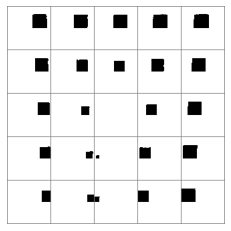

In [16]:
plot_manifold(latent_space_snapshots[0], latent_space_grid)
plt.savefig(fig_root / "shapes-manifold-plain.png", dpi=200)
plt.show()

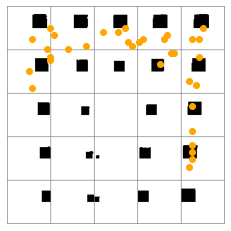

In [17]:
plot_manifold(latent_space_snapshots[0], latent_space_grid)
plt.scatter(opt_latent_points[::15, 0], opt_latent_points[::15, 1], marker="o", color=point_color)
plt.savefig(fig_root / "shapes-manifold-plain-data.png", dpi=200)
plt.show()

## LSO with weighted retraining

In [18]:
# Plot 1: near beginning of the process
with np.load("../../assets/official_results/shapes/rank/k_1e-3/r_5/seed3/results.npz") as npz:
    latent_space_grid = npz["latent_space_grid"]
    latent_space_snapshot_version = npz["latent_space_snapshot_version"]
    latent_space_snapshots = npz["latent_space_snapshots"]
    opt_latent_points = npz["opt_latent_points"]

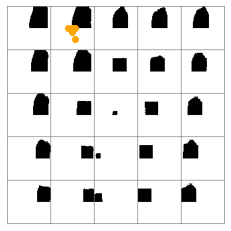

In [19]:
idx = 10
offset = 0
plot_manifold(latent_space_snapshots[idx], latent_space_grid)
plt.scatter(opt_latent_points[5*idx - offset:5*idx+5, 0], opt_latent_points[5*idx - offset:5*idx+5, 1], marker="o", color=point_color)
plt.savefig(fig_root / "shapes-manifold-wr-1.png", dpi=200)
plt.show()

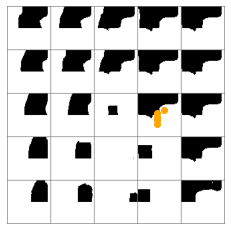

In [20]:
idx = 99
offset = 0
plot_manifold(latent_space_snapshots[idx], latent_space_grid)
plt.scatter(opt_latent_points[5*idx - offset:5*idx+5, 0], opt_latent_points[5*idx - offset:5*idx+5, 1], marker="o", color=point_color)
plt.savefig(fig_root / "shapes-manifold-wr-2.png", dpi=200)
plt.show()

# Make latent space animations

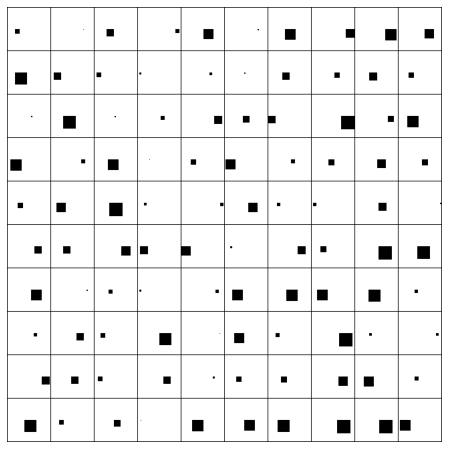

In [21]:
# General dataset plot
%matplotlib inline
N_PLOT = 10
with np.load("../../data/shapes/squares_G64_S1-20_seed0_R10_mnc32_mxc33.npz") as npz:
    shapes_train_imgs = npz["data"]
img = make_grid(torch.as_tensor(shapes_train_imgs[:N_PLOT**2]).unsqueeze(1), 
                nrow=N_PLOT, padding=1, pad_value=1.0).numpy()
img = img[0]
img = img.T
plt.imshow(img, cmap="binary")
plt.axis('off')
plt.gcf().set_size_inches(8, 8)
plt.savefig(fig_root / "shapes-train-data-samples.png", dpi=250)
plt.show()

In [22]:
# General plotting parameters
NROW = 7
my_latent_grid = np.linspace(-3, 3, NROW)
figsize = 6
lim1, lim2 = -3.5, 3.5  # boundary + half the point distance, so points are at center of images
point_color = "orange"
ANI_DPI = 200

def plot_manifold(latent_space_snapshot, latent_space_grid, plot=True):
    
    # Find the subset of points that we want to plot
    good_idx = [] 
    for i in range(len(latent_space_grid)):
        if all(any([np.isclose(x, y) for y in my_latent_grid]) for x in latent_space_grid[i]):
               good_idx.append(i)
                
    # Make image grid
    img = make_grid(torch.as_tensor(latent_space_snapshot[good_idx]).unsqueeze(1), nrow=NROW, padding=1, pad_value=0.5).numpy()
    img = img[0]
    img = img.T
    
    # Plot in a particular way
    if plot:
        im = plt.imshow(img, extent=(lim1, lim2, lim1, lim2), origin="lower", cmap="binary")
        plt.axis('off')
        plt.gcf().set_size_inches(figsize, figsize)
        return im
    else:
        return img

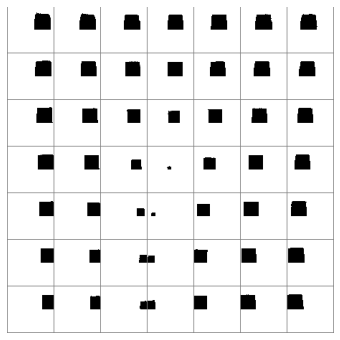

In [23]:
plot_manifold(latent_space_snapshots[0], latent_space_grid)
plt.savefig(fig_root / "shapes-manifold-large.png", dpi=200)
plt.show()

## Normal LSO

In [29]:
# Plot 1: just the latent manifold
with np.load("../../assets/official_results/shapes/rank/k_inf/r_1000000/seed3/results.npz") as npz:
    latent_space_grid = npz["latent_space_grid"]
    latent_space_snapshot_version = npz["latent_space_snapshot_version"]
    latent_space_snapshots = npz["latent_space_snapshots"]
    opt_latent_points = npz["opt_latent_points"]

In [30]:
import matplotlib.animation as animation
%matplotlib notebook

In [31]:
fig1 = plt.figure()
plot_manifold(latent_space_snapshots[0], latent_space_grid)
line, = plt.plot([], [], "o", color=point_color)

def update_image(num, line, ax):
    arr = opt_latent_points[:num]
    line.set_xdata(arr[:, 0])
    line.set_ydata(arr[:, 1])
    ax.set_title(f"Query {num:>3d}")
line_ani = animation.FuncAnimation(fig1, update_image, 500, fargs=(line, plt.gca()),
                                   interval=5, blit=True)
line_ani.save(str(fig_root / "normal-lso-ani.mp4"), dpi=ANI_DPI)
plt.close()
plt.show()

<IPython.core.display.Javascript object>

## LSO with weighted retraining

In [32]:
# Plot 1: near beginning of the process
with np.load("../../assets/official_results/shapes/rank/k_1e-3/r_5/seed3/results.npz") as npz:
    latent_space_grid = npz["latent_space_grid"]
    latent_space_snapshot_version = npz["latent_space_snapshot_version"]
    latent_space_snapshots = npz["latent_space_snapshots"]
    opt_latent_points = npz["opt_latent_points"]

In [33]:
fig1 = plt.figure()
im = plot_manifold(latent_space_snapshots[0], latent_space_grid)
line, = plt.plot([], [], "o", color=point_color)

def update_image(num, line, im, ax):
    
    query_start = (num // 6) * 5
    query_stop = 5 * (num // 6) + (num % 6)
    model_version = num // 6
    
    if num % 6 == 0:
        im.set_data(plot_manifold(latent_space_snapshots[model_version], latent_space_grid, plot=False))
        line.set_xdata([])
        line.set_ydata([])
    else:
        arr = opt_latent_points[query_start:query_stop]
        line.set_xdata(arr[:, 0])
        line.set_ydata(arr[:, 1])
    ax.set_title(f"Query {query_stop:>3d} | Num Retrains={model_version:>3d}")
line_ani = animation.FuncAnimation(fig1, update_image, 600, fargs=(line, im, plt.gca()),
                                   interval=10, blit=True)
line_ani.save(str(fig_root / "wr-lso-ani.mp4"), dpi=ANI_DPI)
plt.close()
plt.show()

<IPython.core.display.Javascript object>